# Imports 

In [15]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from initialization import Location
from initialization import Grid
import pandas as pd
import seaborn as sns
from SIRD_initialization import Grid


# Basic SIRD Model

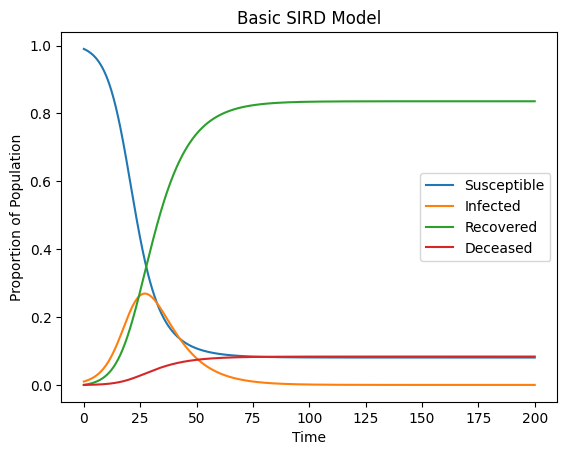

In [16]:
# Define the SIRD model differential equations.
def sird_model(y, t, beta, gamma, delta):
    S, I, R, D = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I - delta * I
    dRdt = gamma * I
    dDdt = delta * I
    return [dSdt, dIdt, dRdt, dDdt]

# Set the initial conditions and parameters.
initial_conditions = [0.99, 0.01, 0, 0]  # S, I, R, D
beta = 0.3  # Infection rate
gamma = 0.1  # Recovery rate
delta = 0.01  # Death rate

# Set the time points for the simulation.
t = np.linspace(0, 200, 1000)

# Solve the ODEs using odeint.
solution = odeint(sird_model, initial_conditions, t, args=(beta, gamma, delta))

# Extract the results.
S, I, R, D = solution.T

# Plot the results.
plt.plot(t, S, label='Susceptible')
plt.plot(t, I, label='Infected')
plt.plot(t, R, label='Recovered')
plt.plot(t, D, label='Deceased')
plt.xlabel('Time')
plt.ylabel('Proportion of Population')
plt.title('Basic SIRD Model')
plt.legend()
plt.show()


## Mobility Based SIRD Model - Random, High, Low

In [21]:
def dynamic_alpha(type, threshold, beta, mu, N, n_locations, days, alpha_range, trials, c, delta_c, delta_g, birth_rate):
    alpha_sir = {}
    for alpha in alpha_range:
        susceptible = np.zeros(days)
        infectious = np.zeros(days)
        recovered = np.zeros(days) 
        dead = np.zeros(days)
        for trial in range(trials):
    
            # Initialize grid and locations
            grid = Grid(n_locations, N, alpha, beta, mu, c)

            # Initialize random starting location based on chosen Mobility Type
            if type == "Random":
                grid.random_orgin()
            elif type == "High Mobility":
                grid.mobility_based_origin(threshold, True)
            else:
                grid.mobility_based_origin(threshold, False)

            for day in range(days):
                for loc in grid.map:
                    if loc.n != 0:
                        infections, total_connections = get_other_loc_params(grid, loc)

                        # find new infections
                        new_infections = (beta * loc.s * loc.i/ loc.n) + ((alpha*loc.s*infections*beta)/(loc.n+total_connections))

                        # update infections in the location
                        loc.i += new_infections 
                        loc.s -= new_infections
                        
                        # determine number of deaths and remove from population
                        infection_deaths = delta_c * loc.i
                        loc.i -= infection_deaths
                        loc.n -= infection_deaths 
                        loc.d += infection_deaths
                        
                        general_deaths = delta_g * loc.n
                        loc.s -= general_deaths
                        loc.n -= general_deaths
                        loc.d += general_deaths

                        # determine new recoveris
                        new_recoveries = (mu * loc.i) / loc.n
                        loc.i -=  new_recoveries                        
                        loc.r += new_recoveries

                        # birth rate impact on the population
                        born = birth_rate*loc.s
                        loc.n += born 
                        loc.s += born 

                        susceptible[day] += loc.s
                        infectious[day] += loc.i
                        recovered[day] += loc.r
                        dead[day] += loc.d


        susceptible = [day / (trials*N) for day in susceptible]
        infectious = [day / (trials*N) for day in infectious]
        recovered = [day / (trials*N) for day in recovered]
        dead = [day / (trials*N) for day in dead]

        susceptible.insert(0,1)
        infectious.insert(0,1/N)
        recovered.insert(0,0)
        dead.insert(0,0)

        alpha_sir[alpha] = [susceptible, infectious, recovered, dead]
    print(alpha_sir)
    return alpha_sir

def sir_plotting(results, type):
    translation = {0:"S", 1:"I", 2:"R", 3:"D"}
    for key, values in results:
        plt.figure()
        for sublist in values:
            plt.plot(sublist, label=translation[values.index(sublist)])
            plt.title(f'SIR Model w/ {type} Mobility: Alpha = {key}')

        plt.legend()
        plt.xlabel("Generations")
        plt.ylabel("Population Density")
    plt.show()


def get_other_loc_params(grid,loc):
    infections = 0
    total_connections = 0
    for j in loc.connections:
        if grid.map[j].n != 0:
            infections += loc.connections[j] * (grid.map[j].i / grid.map[j].n)
            total_connections += loc.connections[j]
    
    return infections, total_connections

{0.1: [[1, 0.9869863545494998, 0.9750167615638496, 0.9630646485530359, 0.9510982257344678, 0.9390801897299329, 0.9269678192466239, 0.9147135898006005, 0.9022663301326754, 0.8895727361104627, 0.8765787658232294, 0.8632301392625719, 0.8494709822195585, 0.8352397144568775, 0.8204616660067692, 0.8050385971540346, 0.7888361589832926, 0.7716711827514382, 0.753301503781731, 0.7334219338258453, 0.7116708730547686, 0.6876522422300115, 0.6609760406407434, 0.6313173861566834, 0.5984884419786253, 0.5625108445814263, 0.5236701241901001, 0.48253232882448366, 0.4399107494943898, 0.39678599247160556, 0.3541973997544085, 0.313130130675225, 0.27442034597345666, 0.23869539960137398, 0.20635658570965235, 0.177597111846003, 0.15243527986022845, 0.13074487279887587, 0.11228006009741309, 0.0967039464594826, 0.08362747874032915, 0.07265529438815756, 0.06342844448298023, 0.05565393141395141, 0.04911470520915048, 0.043659021156913724, 0.03917480034143645, 0.03556086634857765, 0.03270771300487271, 0.030493670619

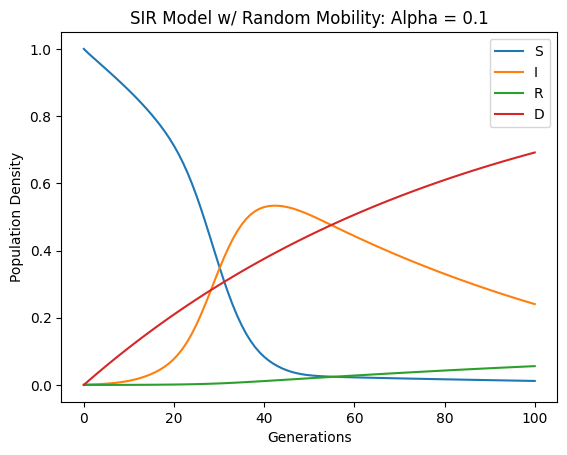

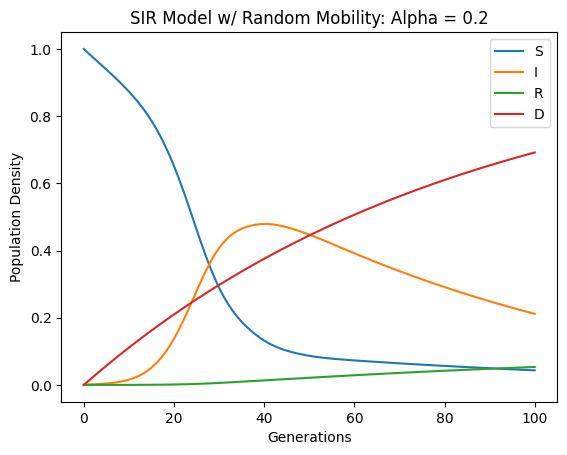

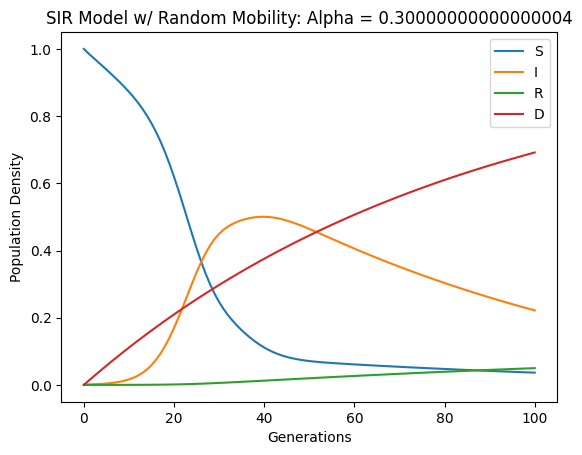

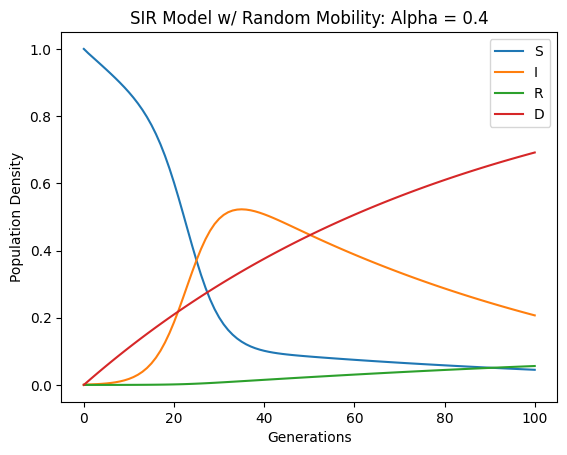

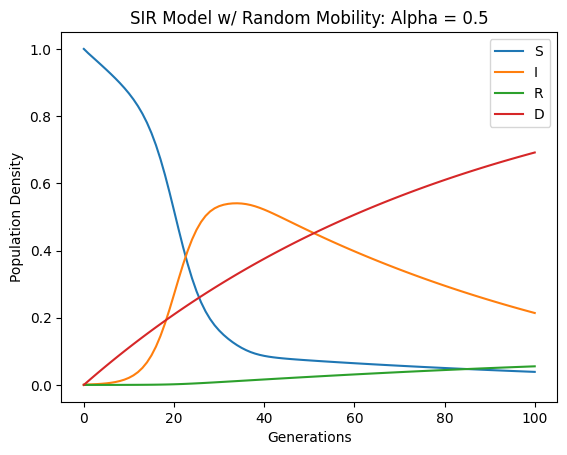

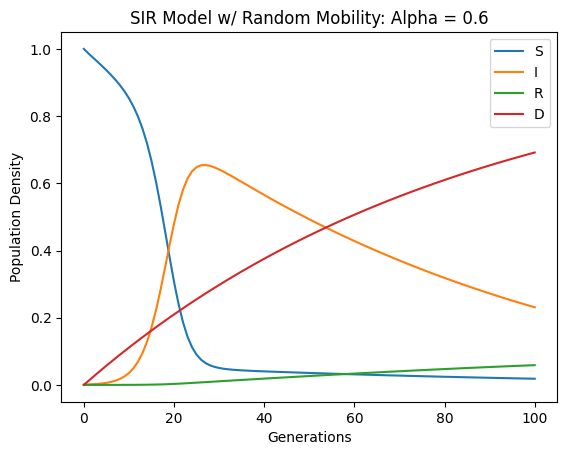

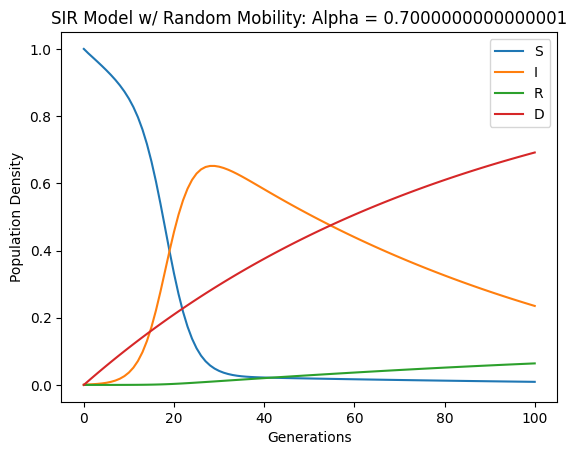

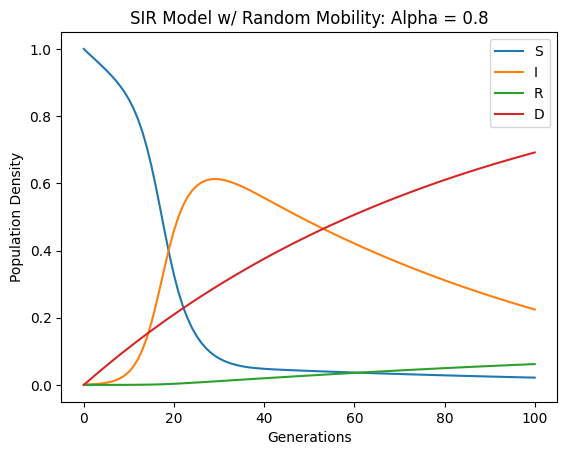

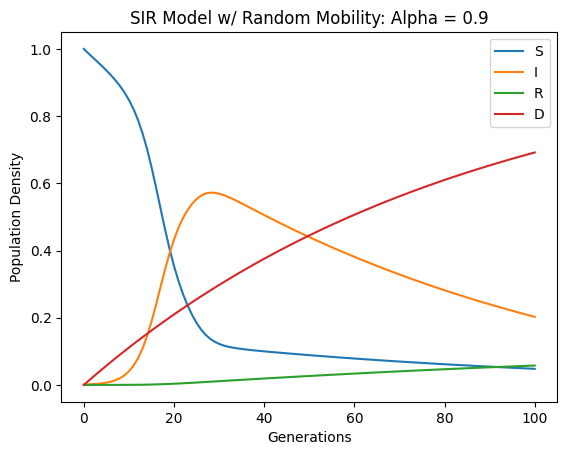

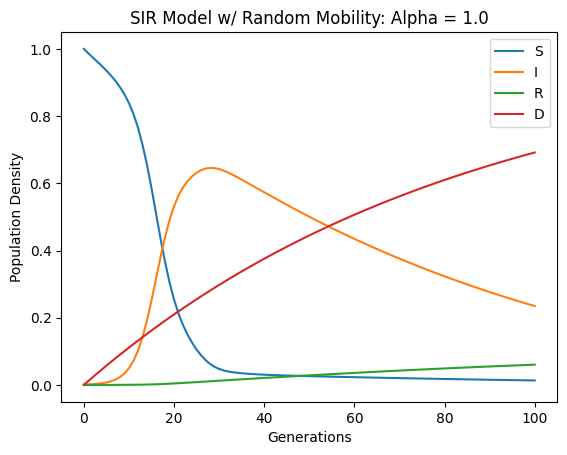

In [23]:
beta = 0.3 # rate of infection *CHANGE LATER MAYBE*
mu = 0.1 # rate of recovery *CHANGE LATER MAYBE*
delta_c = 0#0.04 # rate of death from COVID for Estonia
delta_g = 0.0117 # general death rate in Estonia
birth_rate = 0#0.009898
N = 1000 
n_locations=10
days = 100
alphas = np.arange(0.1,1.1,0.1)
trials=10
c = 0
type = "Random"
threshold = 0.1
dynamic_alpha_results = dynamic_alpha(type, threshold, beta, mu, N, n_locations, days, alphas, trials, c, delta_c, delta_g, birth_rate)
sir_plotting(dynamic_alpha_results.items(), type)
